# Imports

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
import pickle
import dill
import os
import plotly.io as pio

# Setup

In [135]:
config_file = open("./input_settings_darwin.json")
config_vars = json.load(config_file)
config_file.close()


models_dir = config_vars["models_dir"]
input_dir = config_vars["input_dir"]
output_dir = config_vars["output_dir"]

In [136]:
config_file = open("visual_config.json")
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Get Patient Data

In [137]:
diagnosis_data = pd.read_csv(f"{input_dir}/feature_names.csv", header=0)

for file in os.listdir(input_dir):
    if file != "feature_names.csv":
        patient_info = pd.read_csv(f"{input_dir}/{file}", header=None, names=diagnosis_data.columns)
        patient_info = patient_info.rename(index={0: file[:-4]})
        if len(diagnosis_data) == 0:
            diagnosis_data = patient_info
        else:
            diagnosis_data = pd.concat([diagnosis_data, patient_info])

# Classification

In [138]:
diagnosis_data

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,mean_jerk_on_paper1,mean_speed_in_air1,mean_speed_on_paper1,num_of_pendown1,paper_time1,pressure_mean1,pressure_var1,total_time1,air_time2,disp_index2,gmrt_in_air2,gmrt_on_paper2,max_x_extension2,max_y_extension2,mean_acc_in_air2,mean_acc_on_paper2,mean_gmrt2,mean_jerk_in_air2,mean_jerk_on_paper2,mean_speed_in_air2,mean_speed_on_paper2,num_of_pendown2,paper_time2,pressure_mean2,pressure_var2,total_time2,air_time3,disp_index3,gmrt_in_air3,gmrt_on_paper3,max_x_extension3,max_y_extension3,mean_acc_in_air3,mean_acc_on_paper3,mean_gmrt3,mean_jerk_in_air3,mean_jerk_on_paper3,mean_speed_in_air3,mean_speed_on_paper3,num_of_pendown3,paper_time3,pressure_mean3,pressure_var3,total_time3,air_time4,disp_index4,gmrt_in_air4,gmrt_on_paper4,max_x_extension4,max_y_extension4,mean_acc_in_air4,mean_acc_on_paper4,mean_gmrt4,mean_jerk_in_air4,mean_jerk_on_paper4,mean_speed_in_air4,mean_speed_on_paper4,num_of_pendown4,paper_time4,pressure_mean4,pressure_var4,total_time4,air_time5,disp_index5,gmrt_in_air5,gmrt_on_paper5,max_x_extension5,max_y_extension5,mean_acc_in_air5,mean_acc_on_paper5,mean_gmrt5,mean_jerk_in_air5,mean_jerk_on_paper5,mean_speed_in_air5,mean_speed_on_paper5,num_of_pendown5,paper_time5,pressure_mean5,pressure_var5,total_time5,air_time6,disp_index6,gmrt_in_air6,gmrt_on_paper6,max_x_extension6,max_y_extension6,mean_acc_in_air6,mean_acc_on_paper6,mean_gmrt6,mean_jerk_in_air6,mean_jerk_on_paper6,mean_speed_in_air6,mean_speed_on_paper6,num_of_pendown6,paper_time6,pressure_mean6,pressure_var6,total_time6,air_time7,disp_index7,gmrt_in_air7,gmrt_on_paper7,max_x_extension7,max_y_extension7,mean_acc_in_air7,mean_acc_on_paper7,mean_gmrt7,mean_jerk_in_air7,mean_jerk_on_paper7,mean_speed_in_air7,mean_speed_on_paper7,num_of_pendown7,paper_time7,pressure_mean7,pressure_var7,total_time7,air_time8,disp_index8,gmrt_in_air8,gmrt_on_paper8,max_x_extension8,max_y_extension8,mean_acc_in_air8,mean_acc_on_paper8,mean_gmrt8,mean_jerk_in_air8,mean_jerk_on_paper8,mean_speed_in_air8,mean_speed_on_paper8,num_of_pendown8,paper_time8,pressure_mean8,pressure_var8,total_time8,air_time9,disp_index9,gmrt_in_air9,gmrt_on_paper9,max_x_extension9,max_y_extension9,mean_acc_in_air9,mean_acc_on_paper9,mean_gmrt9,mean_jerk_in_air9,mean_jerk_on_paper9,mean_speed_in_air9,mean_speed_on_paper9,num_of_pendown9,paper_time9,pressure_mean9,pressure_var9,total_time9,air_time10,disp_index10,gmrt_in_air10,gmrt_on_paper10,max_x_extension10,max_y_extension10,mean_acc_in_air10,mean_acc_on_paper10,mean_gmrt10,mean_jerk_in_air10,mean_jerk_on_paper10,mean_speed_in_air10,mean_speed_on_paper10,num_of_pendown10,paper_time10,pressure_mean10,pressure_var10,total_time10,air_time11,disp_index11,gmrt_in_air11,gmrt_on_paper11,max_x_extension11,max_y_extension11,mean_acc_in_air11,mean_acc_on_paper11,mean_gmrt11,mean_jerk_in_air11,mean_jerk_on_paper11,mean_speed_in_air11,mean_speed_on_paper11,num_of_pendown11,paper_time11,pressure_mean11,pressure_var11,total_time11,air_time12,disp_index12,gmrt_in_air12,gmrt_on_paper12,max_x_extension12,max_y_extension12,mean_acc_in_air12,mean_acc_on_paper12,mean_gmrt12,mean_jerk_in_air12,mean_jerk_on_paper12,mean_speed_in_air12,mean_speed_on_paper12,num_of_pendown12,paper_time12,pressure_mean12,pressure_var12,total_time12,air_time13,disp_index13,gmrt_in_air13,gmrt_on_paper13,max_x_extension13,max_y_extension13,mean_acc_in_air13,mean_acc_on_paper13,mean_gmrt13,mean_jerk_in_air13,mean_jerk_on_paper13,mean_speed_in_air13,mean_speed_on_paper13,num_of_pendown13,paper_time13,pressure_mean13,pressure_var13,total_time13,air_time14,disp_index14,gmrt_in_air14,gmrt_on_paper14,max_x_extension14,max_y_extension14,mean_acc_in_air14,mean_acc_on_paper14,mean_gmrt14,mean_jerk_in_air14,mean_jerk_on_paper14,mean_speed_in_air14,mean_speed_on_paper14,num_of_pendown14,paper_time14,pressure_mean14,pressure_var14,total_time14,air_time15,disp_i

In [139]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [140]:
filename="DARWIN_LR.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lr_clf = pickle.load(file)

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [141]:
filename = "DARWIN_LIME.dill"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lime_explainer = dill.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [142]:
filename = "DARWIN_LR_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lr_shap_explainer = pickle.load(file)

## <i>Random Forest</i> (RF)

In [143]:
filename="DARWIN_RF.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    rf_clf = pickle.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [144]:
filename = "DARWIN_RF_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    rf_shap_explainer = pickle.load(file)

## <i> Support Vector Machines</i> (SVM)

In [145]:
filename="DARWIN_SVM.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    svm_clf = pickle.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [146]:
filename = "DARWIN_SVM_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    svm_shap_explainer = pickle.load(file)

## <i>Explainable Boosting Machine</i> (EBM)

In [147]:
filename="DARWIN_EBM_no_interactions.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    ebm_clf = pickle.load(file)

## Predictions & Explanations

In [148]:
latex_str = "PID & LR & RF & SVM & EBM \\\ \n"

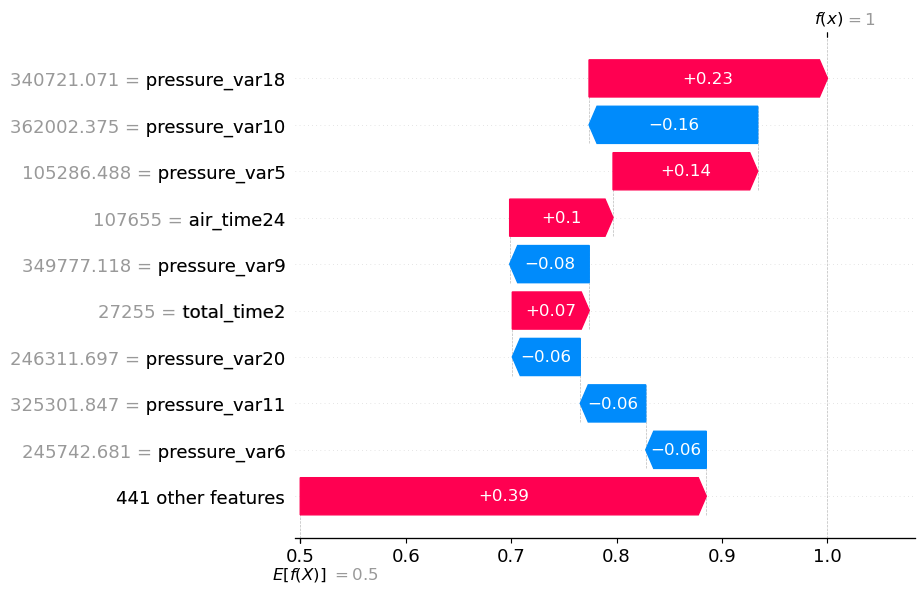

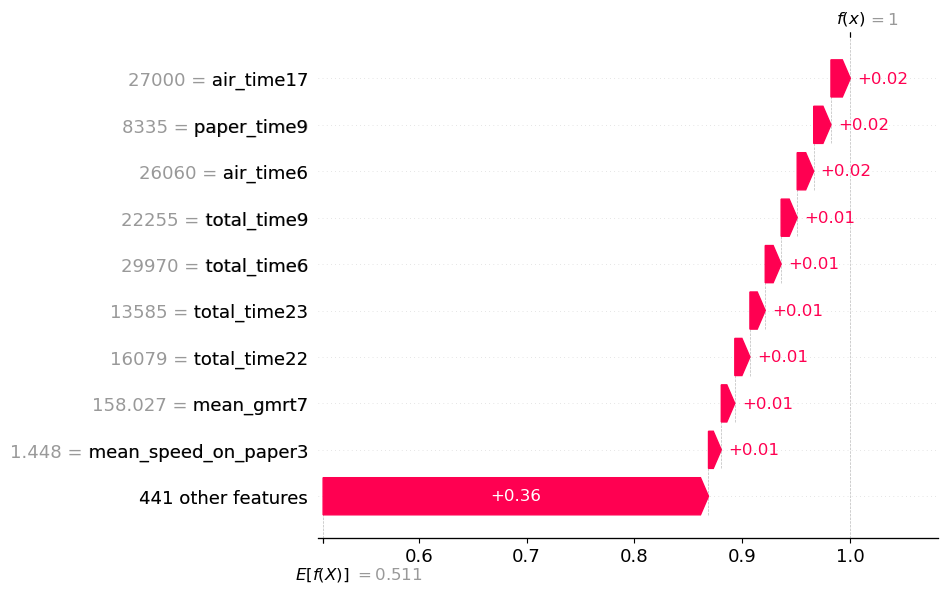

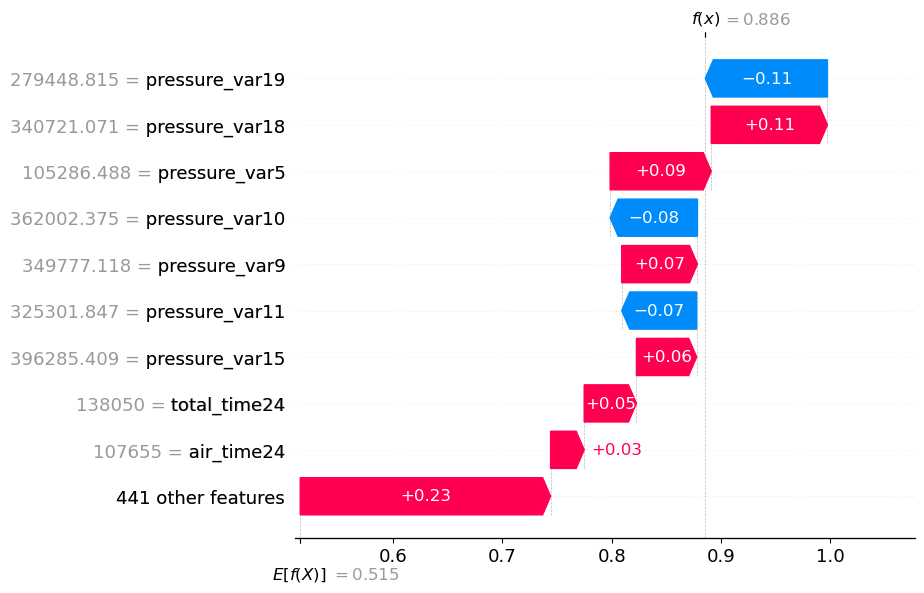

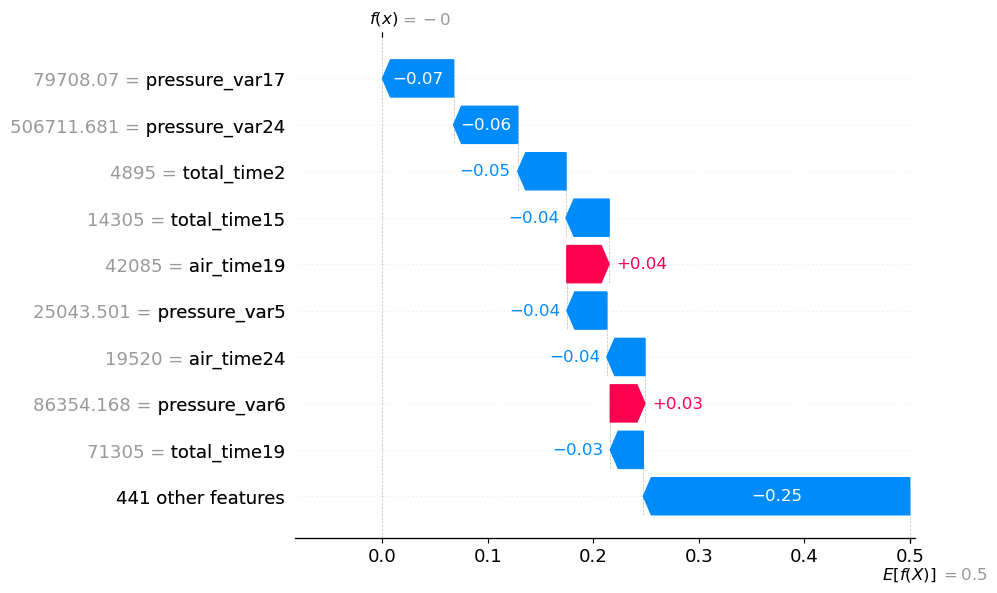

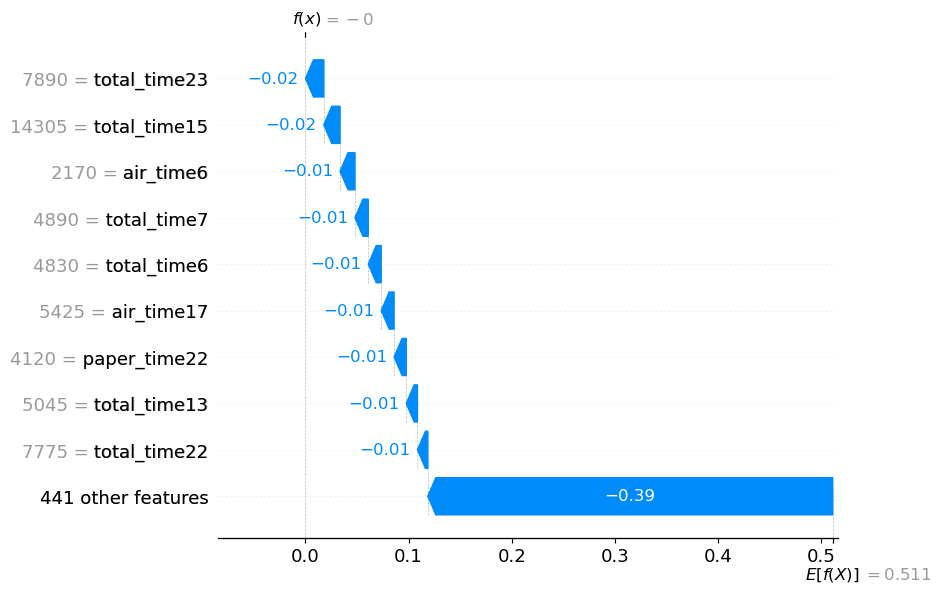

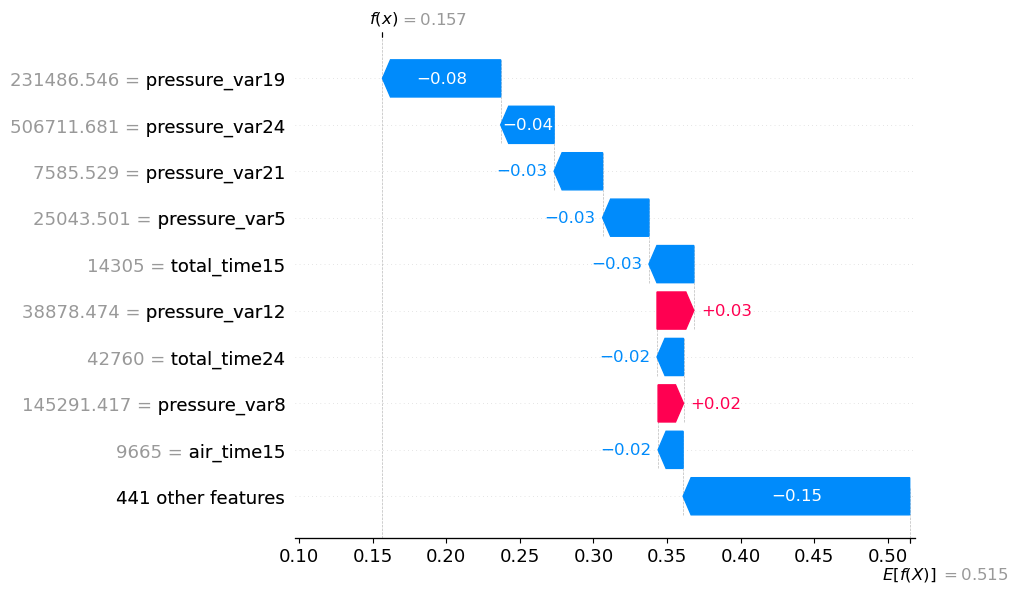

In [149]:
for index, row in diagnosis_data.iterrows():
    
    row_pd = pd.DataFrame([row.to_numpy()], columns=diagnosis_data.columns)
    row_np = row.to_numpy()
    
    ## Predictions
    pred_lr = lr_clf.predict([row_np])
    pred_rf = rf_clf.predict([row_np])
    pred_svm = svm_clf.predict([row_np])
    pred_ebm = ebm_clf.predict([row_np])
    
    latex_row = f"{index} & {pred_lr[0]} & {pred_rf[0]} & {pred_svm[0]} & {pred_ebm[0]} \\\ \n"
    latex_str += latex_row
    
    
    ## LIME
    lr_lime_explanation = lime_explainer.explain_instance(row_np, lr_clf.predict_proba)
    lr_lime_explanation.save_to_file(f"{output_dir}/lr_lime_{index}.html")
    rf_lime_explanation = lime_explainer.explain_instance(row_np, rf_clf.predict_proba)
    rf_lime_explanation.save_to_file(f"{output_dir}/rf_lime_{index}.html")
    svm_lime_explanation = lime_explainer.explain_instance(row_np, svm_clf.predict_proba)
    svm_lime_explanation.save_to_file(f"{output_dir}/svm_lime_{index}.html")


    ## SHAP
    lr_shap_loc_values = np.array(lr_shap_explainer.shap_values(row))
    rf_shap_loc_values = np.array(rf_shap_explainer.shap_values(row))
    svm_shap_loc_values = np.array(svm_shap_explainer.shap_values(row))


    explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_shap_explainer.expected_value[1], data=row),
                shap.Explanation(rf_shap_loc_values[1, :], rf_shap_explainer.expected_value[1], data=row),
                shap.Explanation(svm_shap_loc_values[1, :], svm_shap_explainer.expected_value[1], data=row)]


    shap.plots.waterfall(explanations[0], show=False)
    plt.gcf().savefig(f"{output_dir}/lr_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    shap.plots.waterfall(explanations[1], show=False)
    plt.gcf().savefig(f"{output_dir}/rf_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    shap.plots.waterfall(explanations[2], show=False)
    plt.gcf().savefig(f"{output_dir}/svm_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    
    
    ## EBM
    ebm_local = ebm_clf.explain_local(row_pd)
    plot = ebm_local.visualize(0) 
    pio.write_image(plot, f"{output_dir}/ebm_local_{index}_no_interactions.png", format='png', width=1280, height=720)
    

In [150]:
with open(f"{output_dir}/patients_predictions.txt", "w") as text_file:
    print(latex_str, file=text_file)